<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-03-31 03:23:45--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.004s  

2023-03-31 03:23:45 (66.7 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


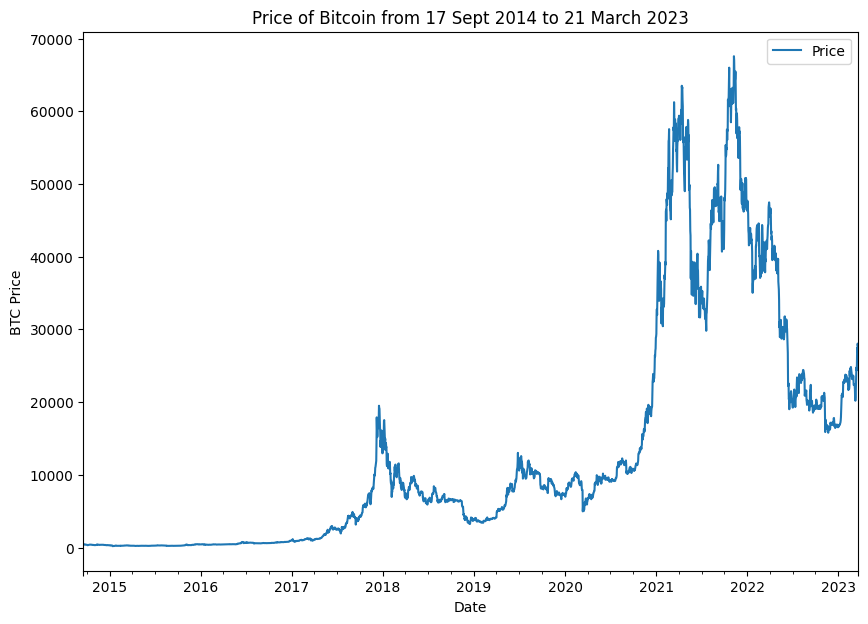

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

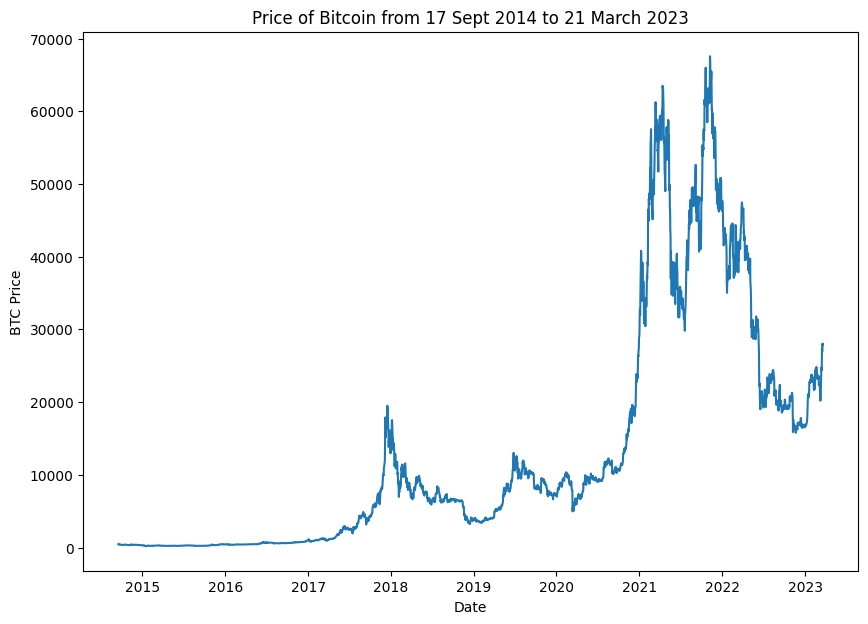

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

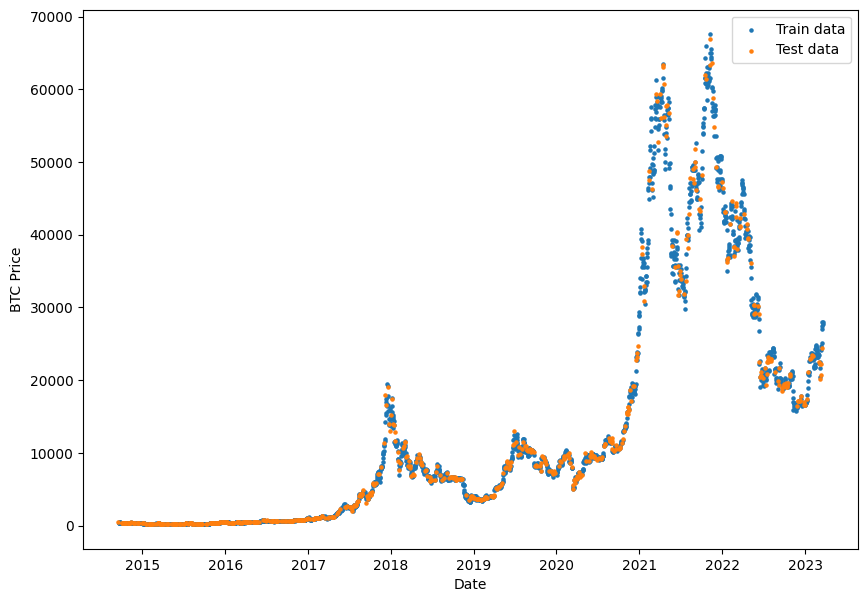

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

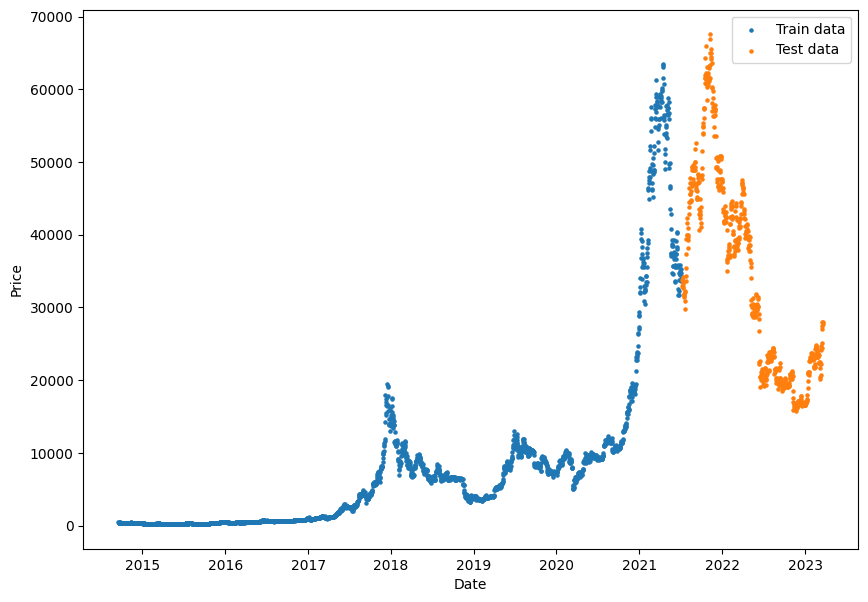

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

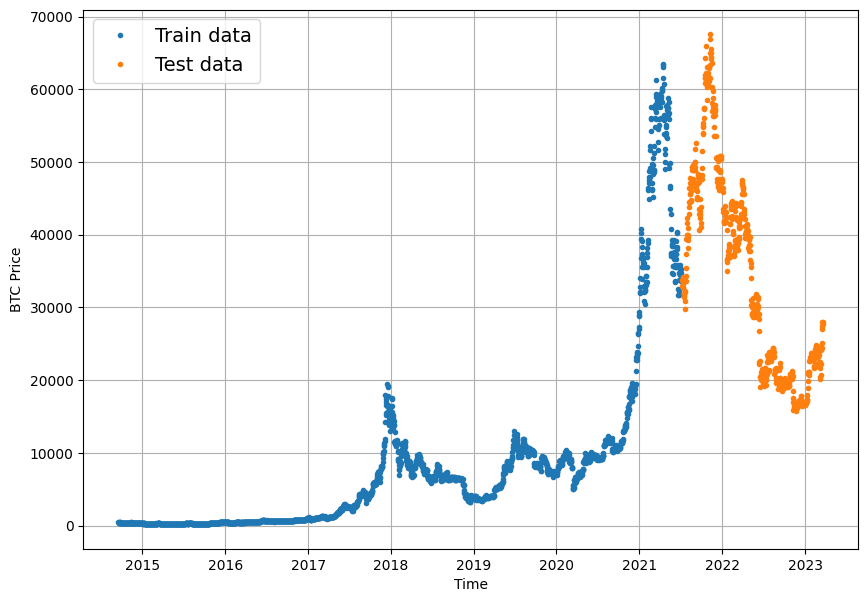

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

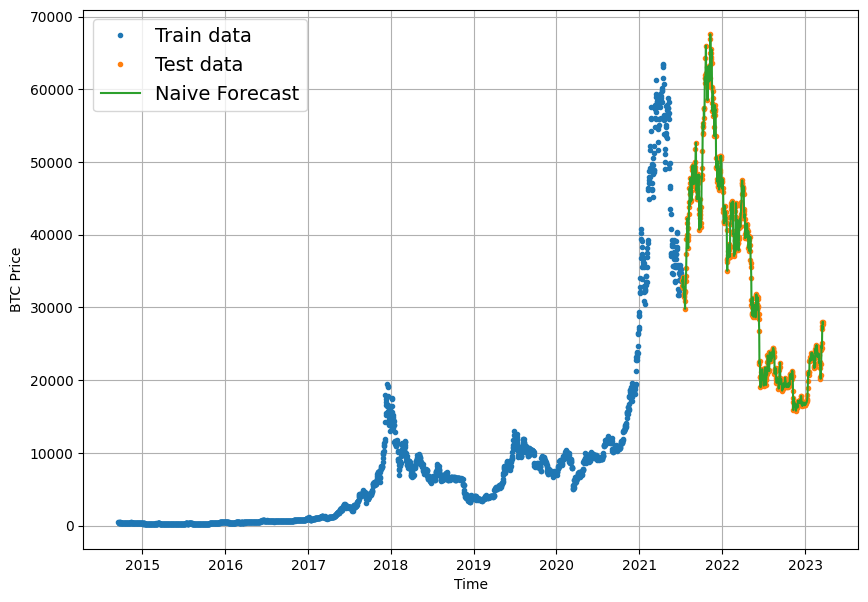

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


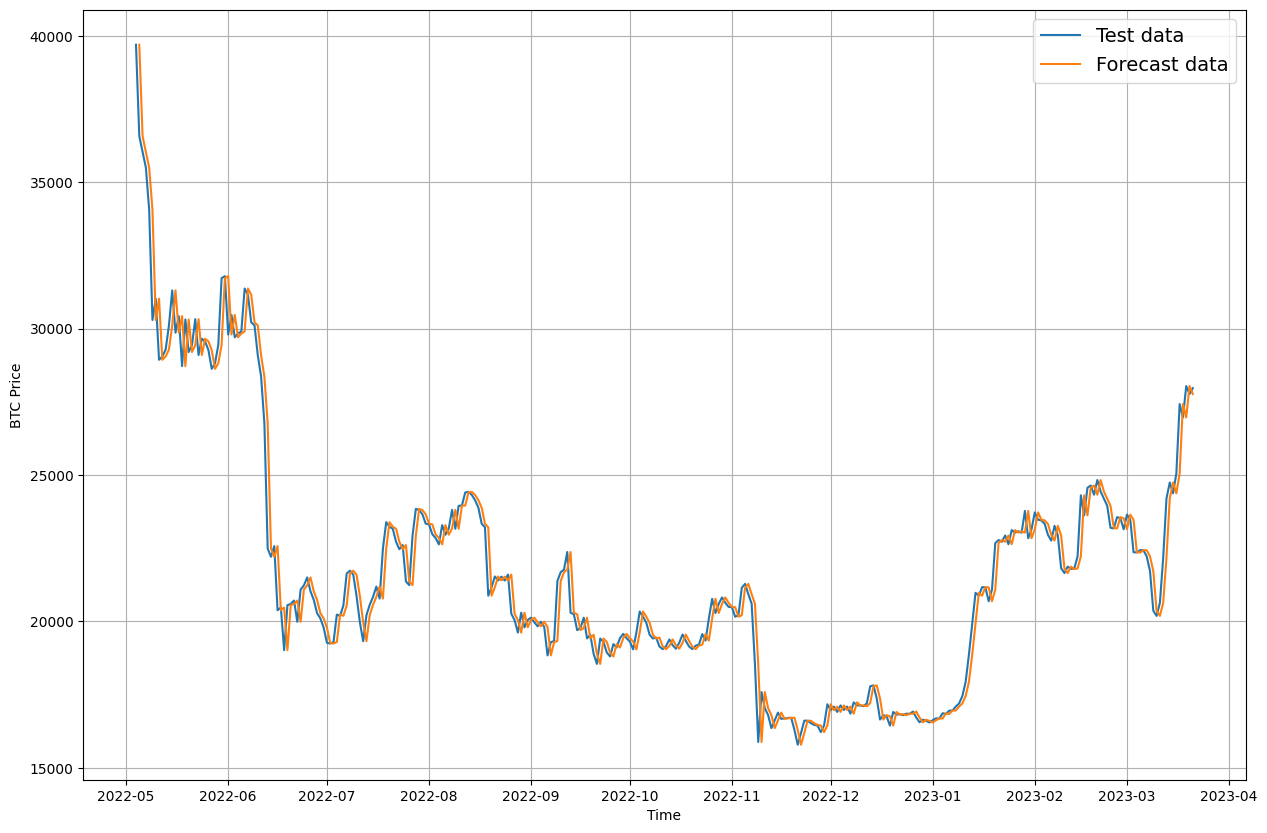

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/20 [>.............................] - ETA: 14s - loss: 4779.4253 - mae: 4779.4253

20/20 [==============================] - 2s 48ms/step - loss: 1960.4087 - mae: 1960.4087 - val_loss: 2877.8044 - val_mae: 2877.8044
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 763.4603 - mae: 763.4603

20/20 [==============================] - 1s 30ms/step - loss: 543.6032 - mae: 543.6032 - val_loss: 1671.5145 - val_mae: 1671.5145
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 433.5513 - mae: 433.5513

20/20 [==============================] - 1s 37ms/step - loss: 430.1993 - mae: 430.1993 - val_loss: 1343.4707 - val_mae: 1343.4707
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 416.7889 - mae: 416.7889 - val_loss: 1483.4128 - val_mae: 1483.4128
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 439.6175 - mae: 439.6175

20/20 [==============================] - 1s 48ms/step - loss: 411.4323 - mae: 411.4323 - val_loss: 1296.3291 - val_mae: 1296.3291
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 393.5802 - mae: 393.5802 - val_loss: 1351.6322 - val_mae: 1351.6322
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 295.9611 - mae: 295.9611

20/20 [==============================] - 1s 44ms/step - loss: 392.2680 - mae: 392.2680 - val_loss: 1211.4308 - val_mae: 1211.4308
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 410.4037 - mae: 410.4037 - val_loss: 1276.1218 - val_mae: 1276.1218
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 394.7758 - mae: 394.7758 - val_loss: 1386.3738 - val_mae: 1386.3738
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 418.6561 - mae: 418.6561

20/20 [==============================] - 1s 32ms/step - loss: 363.3897 - mae: 363.3897 - val_loss: 1141.0914 - val_mae: 1141.0914
Epoch 11/100
 1/20 [>.............................] - ETA: 0s - loss: 340.5522 - mae: 340.5522

20/20 [==============================] - 1s 64ms/step - loss: 345.2339 - mae: 345.2339 - val_loss: 1121.8479 - val_mae: 1121.8479
Epoch 12/100
11/20 [===============>..............] - ETA: 0s - loss: 349.4923 - mae: 349.4923

20/20 [==============================] - 1s 63ms/step - loss: 336.5324 - mae: 336.5324 - val_loss: 1077.6595 - val_mae: 1077.6595
Epoch 13/100
20/20 [==============================] - 0s 6ms/step - loss: 336.3189 - mae: 336.3189 - val_loss: 1128.6859 - val_mae: 1128.6859
Epoch 14/100
14/20 [====================>.........] - ETA: 0s - loss: 328.5944 - mae: 328.5944

20/20 [==============================] - 1s 56ms/step - loss: 320.1391 - mae: 320.1391 - val_loss: 1074.6287 - val_mae: 1074.6287
Epoch 15/100
20/20 [==============================] - 0s 8ms/step - loss: 316.7893 - mae: 316.7893 - val_loss: 1075.6952 - val_mae: 1075.6952
Epoch 16/100
20/20 [==============================] - 0s 10ms/step - loss: 315.0128 - mae: 315.0128 - val_loss: 1118.3802 - val_mae: 1118.3802
Epoch 17/100
20/20 [==============================] - 0s 6ms/step - loss: 317.6997 - mae: 317.6997 - val_loss: 1103.5670 - val_mae: 1103.5670
Epoch 18/100
20/20 [==============================] - 0s 5ms/step - loss: 307.2317 - mae: 307.2317 - val_loss: 1312.2605 - val_mae: 1312.2605
Epoch 19/100
20/20 [==============================] - 0s 10ms/step - loss: 326.2742 - mae: 326.2742 - val_loss: 1187.9590 - val_mae: 1187.9590
Epoch 20/100
20/20 [==============================] - 0s 6ms/step - loss: 345.5716 - mae: 345.5716 - val_loss: 1202.7860 - val_mae: 1202.7860
Epoch 21/100
12/

20/20 [==============================] - 1s 60ms/step - loss: 324.2294 - mae: 324.2294 - val_loss: 1025.2834 - val_mae: 1025.2834
Epoch 22/100
16/20 [=======================>......] - ETA: 0s - loss: 324.3008 - mae: 324.3008

20/20 [==============================] - 1s 72ms/step - loss: 318.1371 - mae: 318.1371 - val_loss: 995.7075 - val_mae: 995.7075
Epoch 23/100
20/20 [==============================] - 0s 9ms/step - loss: 290.0025 - mae: 290.0025 - val_loss: 1122.8373 - val_mae: 1122.8373
Epoch 24/100
 1/20 [>.............................] - ETA: 0s - loss: 216.8711 - mae: 216.8711

20/20 [==============================] - 1s 65ms/step - loss: 300.0911 - mae: 300.0911 - val_loss: 957.7812 - val_mae: 957.7812
Epoch 25/100
19/20 [===========================>..] - ETA: 0s - loss: 291.6777 - mae: 291.6777

20/20 [==============================] - 2s 85ms/step - loss: 291.9794 - mae: 291.9794 - val_loss: 956.5079 - val_mae: 956.5079
Epoch 26/100
20/20 [==============================] - 0s 9ms/step - loss: 287.2654 - mae: 287.2654 - val_loss: 987.0045 - val_mae: 987.0045
Epoch 27/100
20/20 [==============================] - 0s 9ms/step - loss: 289.1718 - mae: 289.1718 - val_loss: 1091.6434 - val_mae: 1091.6434
Epoch 28/100
20/20 [==============================] - 0s 15ms/step - loss: 287.1765 - mae: 287.1765 - val_loss: 996.1768 - val_mae: 996.1768
Epoch 29/100
11/20 [===============>..............] - ETA: 0s - loss: 297.3468 - mae: 297.3468

20/20 [==============================] - 2s 106ms/step - loss: 287.3988 - mae: 287.3988 - val_loss: 924.1624 - val_mae: 924.1624
Epoch 30/100
20/20 [==============================] - 0s 7ms/step - loss: 281.9149 - mae: 281.9149 - val_loss: 980.6542 - val_mae: 980.6542
Epoch 31/100
20/20 [==============================] - 0s 10ms/step - loss: 278.6832 - mae: 278.6832 - val_loss: 947.0831 - val_mae: 947.0831
Epoch 32/100
20/20 [==============================] - 0s 7ms/step - loss: 277.4803 - mae: 277.4803 - val_loss: 982.0152 - val_mae: 982.0152
Epoch 33/100
20/20 [==============================] - 0s 8ms/step - loss: 285.5721 - mae: 285.5721 - val_loss: 943.9268 - val_mae: 943.9268
Epoch 34/100
13/20 [==================>...........] - ETA: 0s - loss: 270.8562 - mae: 270.8562

20/20 [==============================] - 1s 53ms/step - loss: 273.7936 - mae: 273.7936 - val_loss: 911.6968 - val_mae: 911.6968
Epoch 35/100
20/20 [==============================] - 0s 7ms/step - loss: 283.9883 - mae: 283.9883 - val_loss: 922.2141 - val_mae: 922.2141
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 281.2342 - mae: 281.2342 - val_loss: 1172.7979 - val_mae: 1172.7979
Epoch 37/100
19/20 [===========================>..] - ETA: 0s - loss: 293.8588 - mae: 293.8588

20/20 [==============================] - 1s 70ms/step - loss: 292.1971 - mae: 292.1971 - val_loss: 910.6631 - val_mae: 910.6631
Epoch 38/100
13/20 [==================>...........] - ETA: 0s - loss: 259.4602 - mae: 259.4602

20/20 [==============================] - 1s 65ms/step - loss: 273.1994 - mae: 273.1994 - val_loss: 900.3559 - val_mae: 900.3559
Epoch 39/100
 1/20 [>.............................] - ETA: 0s - loss: 335.6475 - mae: 335.6475

20/20 [==============================] - 1s 53ms/step - loss: 277.1906 - mae: 277.1906 - val_loss: 896.0693 - val_mae: 896.0693
Epoch 40/100
20/20 [==============================] - 0s 9ms/step - loss: 303.1709 - mae: 303.1709 - val_loss: 1225.3650 - val_mae: 1225.3650
Epoch 41/100
20/20 [==============================] - 0s 9ms/step - loss: 306.9669 - mae: 306.9669 - val_loss: 1088.2141 - val_mae: 1088.2141
Epoch 42/100
20/20 [==============================] - 0s 9ms/step - loss: 285.9950 - mae: 285.9950 - val_loss: 912.6230 - val_mae: 912.6230
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 268.5682 - mae: 268.5682 - val_loss: 946.4845 - val_mae: 946.4845
Epoch 44/100
20/20 [==============================] - 0s 6ms/step - loss: 279.3339 - mae: 279.3339 - val_loss: 901.0453 - val_mae: 901.0453
Epoch 45/100
16/20 [=======================>......] - ETA: 0s - loss: 294.3589 - mae: 294.3589

20/20 [==============================] - 2s 102ms/step - loss: 283.7560 - mae: 283.7560 - val_loss: 885.1270 - val_mae: 885.1270
Epoch 46/100
20/20 [==============================] - 0s 10ms/step - loss: 278.6352 - mae: 278.6352 - val_loss: 1012.9832 - val_mae: 1012.9832
Epoch 47/100
20/20 [==============================] - 0s 5ms/step - loss: 271.3360 - mae: 271.3360 - val_loss: 885.5955 - val_mae: 885.5955
Epoch 48/100
20/20 [==============================] - 0s 6ms/step - loss: 265.5865 - mae: 265.5865 - val_loss: 885.2100 - val_mae: 885.2100
Epoch 49/100
 1/20 [>.............................] - ETA: 0s - loss: 346.0860 - mae: 346.0860

20/20 [==============================] - 2s 93ms/step - loss: 266.6014 - mae: 266.6014 - val_loss: 879.1241 - val_mae: 879.1241
Epoch 50/100
13/20 [==================>...........] - ETA: 0s - loss: 278.4601 - mae: 278.4601

20/20 [==============================] - 2s 105ms/step - loss: 262.4460 - mae: 262.4460 - val_loss: 874.7130 - val_mae: 874.7130
Epoch 51/100
20/20 [==============================] - 0s 9ms/step - loss: 264.6979 - mae: 264.6979 - val_loss: 1002.9861 - val_mae: 1002.9861
Epoch 52/100
17/20 [========================>.....] - ETA: 0s - loss: 266.6065 - mae: 266.6065

20/20 [==============================] - 2s 101ms/step - loss: 264.1267 - mae: 264.1267 - val_loss: 871.8260 - val_mae: 871.8260
Epoch 53/100
20/20 [==============================] - 0s 3ms/step - loss: 264.1669 - mae: 264.1669 - val_loss: 944.8405 - val_mae: 944.8405
Epoch 54/100
20/20 [==============================] - 0s 3ms/step - loss: 269.0791 - mae: 269.0791 - val_loss: 872.4246 - val_mae: 872.4246
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 272.2398 - mae: 272.2398 - val_loss: 1075.8505 - val_mae: 1075.8505
Epoch 56/100
 1/20 [>.............................] - ETA: 0s - loss: 406.9982 - mae: 406.9982

20/20 [==============================] - 1s 30ms/step - loss: 286.9030 - mae: 286.9030 - val_loss: 865.2582 - val_mae: 865.2582
Epoch 57/100
20/20 [==============================] - 0s 3ms/step - loss: 265.7910 - mae: 265.7910 - val_loss: 882.7578 - val_mae: 882.7578
Epoch 58/100
20/20 [==============================] - 0s 3ms/step - loss: 268.6195 - mae: 268.6195 - val_loss: 900.8911 - val_mae: 900.8911
Epoch 59/100
20/20 [==============================] - 0s 4ms/step - loss: 258.9076 - mae: 258.9076 - val_loss: 867.8905 - val_mae: 867.8905
Epoch 60/100
 1/20 [>.............................] - ETA: 0s - loss: 235.3791 - mae: 235.3791

20/20 [==============================] - 1s 29ms/step - loss: 258.6884 - mae: 258.6884 - val_loss: 864.4781 - val_mae: 864.4781
Epoch 61/100
20/20 [==============================] - 0s 4ms/step - loss: 264.5952 - mae: 264.5952 - val_loss: 876.8579 - val_mae: 876.8579
Epoch 62/100
20/20 [==============================] - 0s 3ms/step - loss: 272.1811 - mae: 272.1811 - val_loss: 934.9417 - val_mae: 934.9417
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 263.3683 - mae: 263.3683 - val_loss: 964.7072 - val_mae: 964.7072
Epoch 64/100
 1/20 [>.............................] - ETA: 0s - loss: 267.9343 - mae: 267.9343

20/20 [==============================] - 1s 28ms/step - loss: 262.2725 - mae: 262.2725 - val_loss: 853.0614 - val_mae: 853.0614
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 260.4063 - mae: 260.4063 - val_loss: 869.7562 - val_mae: 869.7562
Epoch 66/100
20/20 [==============================] - 0s 3ms/step - loss: 260.9732 - mae: 260.9732 - val_loss: 863.0605 - val_mae: 863.0605
Epoch 67/100
20/20 [==============================] - 0s 3ms/step - loss: 298.9389 - mae: 298.9389 - val_loss: 1166.4120 - val_mae: 1166.4120
Epoch 68/100
20/20 [==============================] - 0s 3ms/step - loss: 261.7068 - mae: 261.7068 - val_loss: 955.0803 - val_mae: 955.0803
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 273.9996 - mae: 273.9996 - val_loss: 891.1140 - val_mae: 891.1140
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 272.0624 - mae: 272.0624 - val_loss: 1164.4590 - val_mae: 1164.4590
Epoch 71/100
20/20 [========

20/20 [==============================] - 1s 29ms/step - loss: 254.6577 - mae: 254.6577 - val_loss: 848.7505 - val_mae: 848.7505
Epoch 77/100
20/20 [==============================] - 0s 4ms/step - loss: 260.9440 - mae: 260.9440 - val_loss: 855.2054 - val_mae: 855.2054
Epoch 78/100
20/20 [==============================] - 0s 3ms/step - loss: 273.1172 - mae: 273.1172 - val_loss: 857.5259 - val_mae: 857.5259
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 255.6242 - mae: 255.6242 - val_loss: 858.9778 - val_mae: 858.9778
Epoch 80/100
20/20 [==============================] - 0s 3ms/step - loss: 272.9691 - mae: 272.9691 - val_loss: 861.8291 - val_mae: 861.8291
Epoch 81/100
20/20 [==============================] - 0s 3ms/step - loss: 259.2903 - mae: 259.2903 - val_loss: 862.3652 - val_mae: 862.3652
Epoch 82/100
20/20 [==============================] - 0s 3ms/step - loss: 284.4299 - mae: 284.4299 - val_loss: 1484.9062 - val_mae: 1484.9062
Epoch 83/100
20/20 [==========

20/20 [==============================] - 1s 29ms/step - loss: 264.9354 - mae: 264.9354 - val_loss: 846.1066 - val_mae: 846.1066
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 254.3031 - mae: 254.3031 - val_loss: 897.4843 - val_mae: 897.4843
Epoch 89/100
20/20 [==============================] - 0s 3ms/step - loss: 266.3922 - mae: 266.3922 - val_loss: 852.7393 - val_mae: 852.7393
Epoch 90/100
20/20 [==============================] - 0s 3ms/step - loss: 252.9281 - mae: 252.9281 - val_loss: 928.9488 - val_mae: 928.9488
Epoch 91/100
20/20 [==============================] - 0s 3ms/step - loss: 256.4682 - mae: 256.4682 - val_loss: 858.8936 - val_mae: 858.8936
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 264.3884 - mae: 264.3884 - val_loss: 985.0186 - val_mae: 985.0186
Epoch 93/100
20/20 [==============================] - 0s 3ms/step - loss: 261.3726 - mae: 261.3726 - val_loss: 861.5829 - val_mae: 861.5829
Epoch 94/100
20/20 [============

In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 862.2452 - mae: 862.2452


[862.2451782226562, 862.2451782226562]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 846.1065 - mae: 846.1065


[846.1065063476562, 846.1065063476562]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33217.742, 33624.13 , 33660.645, 34300.23 , 33518.22 , 32931.43 ,
       32784.605, 32063.256, 31534.775, 31483.678], dtype=float32)>

In [41]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [42]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 846.10657,
 'mse': 1617502.5,
 'rmse': 1271.8107,
 'mape': 2.4571233,
 'mase': 1.0000142}

In [43]:
# view the naive results
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

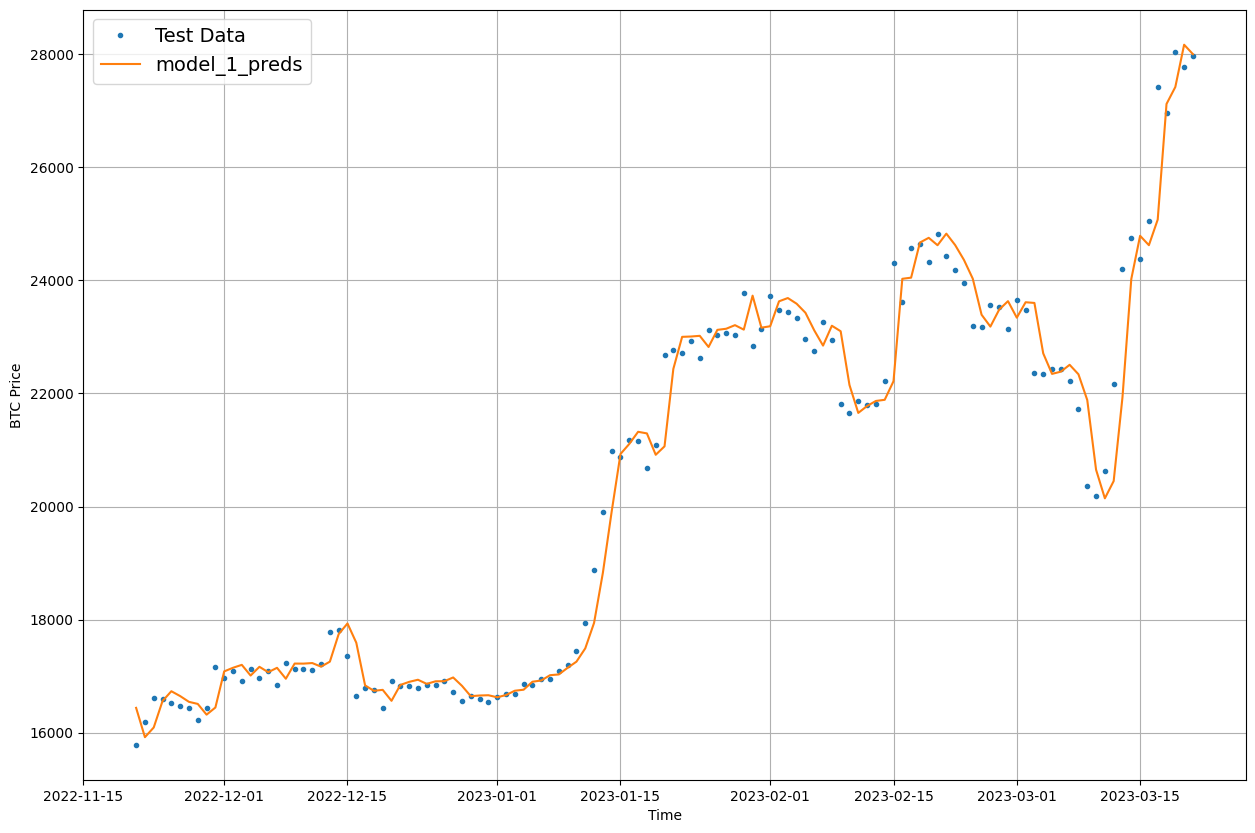

In [44]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [45]:
HORIZON=1
WINDOW_SIZE=30

In [46]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [47]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [48]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 1180.5630


1180.56298828125

In [50]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 899.2950


899.2950439453125

In [51]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 1ms/step


{'mae': 899.29517,
 'mse': 1747637.2,
 'rmse': 1321.9823,
 'mape': 2.609989,
 'mase': 0.99996686}

In [52]:
model_1_results

{'mae': 846.10657,
 'mse': 1617502.5,
 'rmse': 1271.8107,
 'mape': 2.4571233,
 'mase': 1.0000142}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

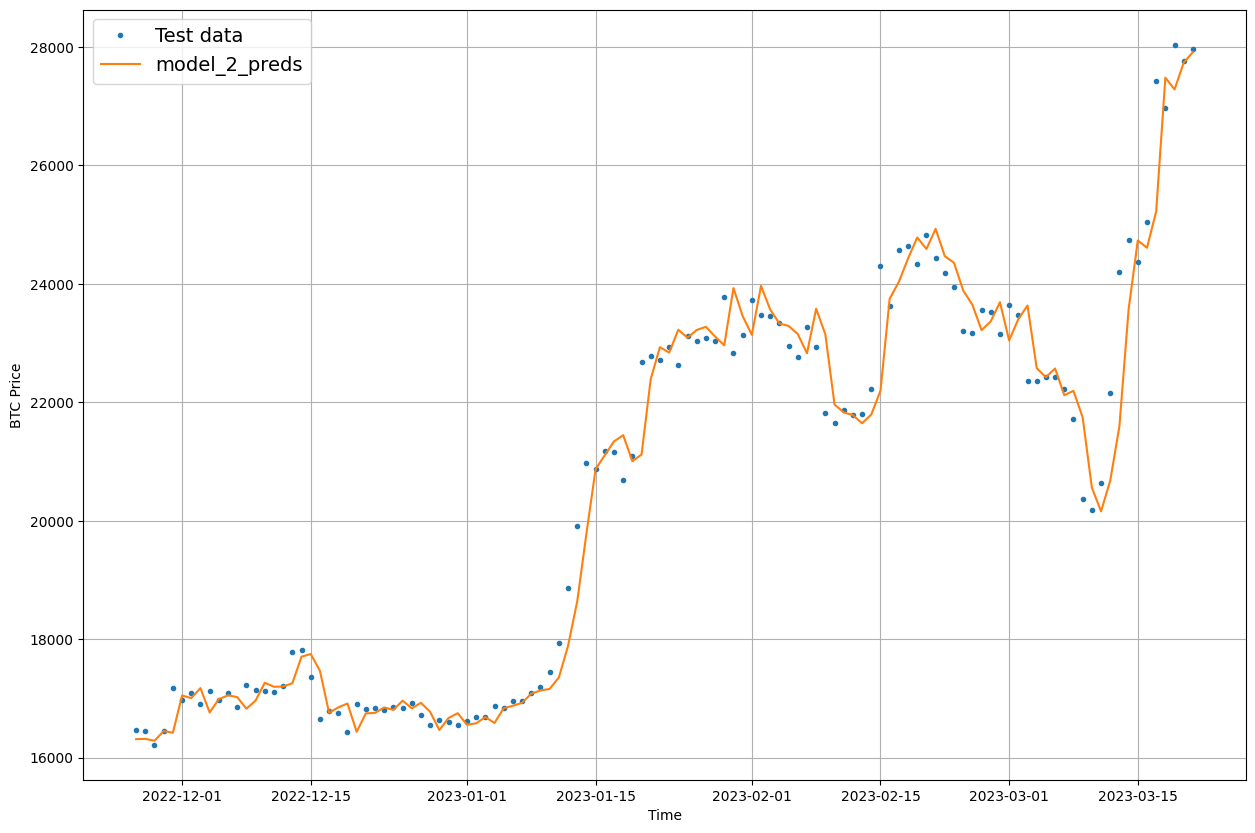

In [53]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [54]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [55]:
len(train_windows), len(test_windows)

(2457, 615)

In [56]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 1781.7002


1781.7001953125

In [58]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1757.6980


1757.697998046875

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [59]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 1ms/step


In [60]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [61]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 797.02374, 1374.6677 , 1059.222  , 1818.9373 , 1779.2001 ,
        1296.2852 , 1158.1116 ,  673.3418 , 1115.7732 , 1429.6705 ,
        1861.6545 , 2867.4297 , 4698.8784 , 4618.975  , 5035.982  ,
        5132.2812 , 4841.6924 , 4662.95   , 3325.2031 , 1417.385  ,
        1080.9861 ,  996.7333 , 1764.0419 , 2520.6072 , 2070.7317 ,
        3079.4175 , 4791.1577 , 5075.2524 , 3969.7527 , 2961.9045 ,
        1463.0408 , 1450.4598 , 1102.1517 , 1387.6686 , 1450.8527 ,
        1249.6345 ,  821.5413 , 1526.472  , 1747.6569 , 2136.855  ,
        2393.405  , 3317.3984 , 2020.7372 , 1146.9894 , 1868.4531 ,
        2037.6189 , 2863.8962 , 1618.4453 , 1275.303  ,  748.7171 ,
         702.02844, 1021.5128 , 1282.2299 , 1794.8795 , 2660.2566 ,
        2548.2148 , 2305.3425 , 3289.9136 , 4132.044  , 4925.4717 ,
        7689.379  , 3918.236  ,  986.6317 ,  971.4403 , 1719.7389 ,
        2259.5256 , 2130.6177 , 2653.5247 , 2109.096  , 3310.5278 ,
        3891.2014 , 3439.4324 , 4771.2373

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [62]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1757.698>

In [63]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [64]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1757.698,
 'mse': 6523673.0,
 'rmse': 2011.3353,
 'mape': 5.190543,
 'mase': 0.99998134}

In [65]:
model_2_results

{'mae': 899.29517,
 'mse': 1747637.2,
 'rmse': 1321.9823,
 'mape': 2.609989,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

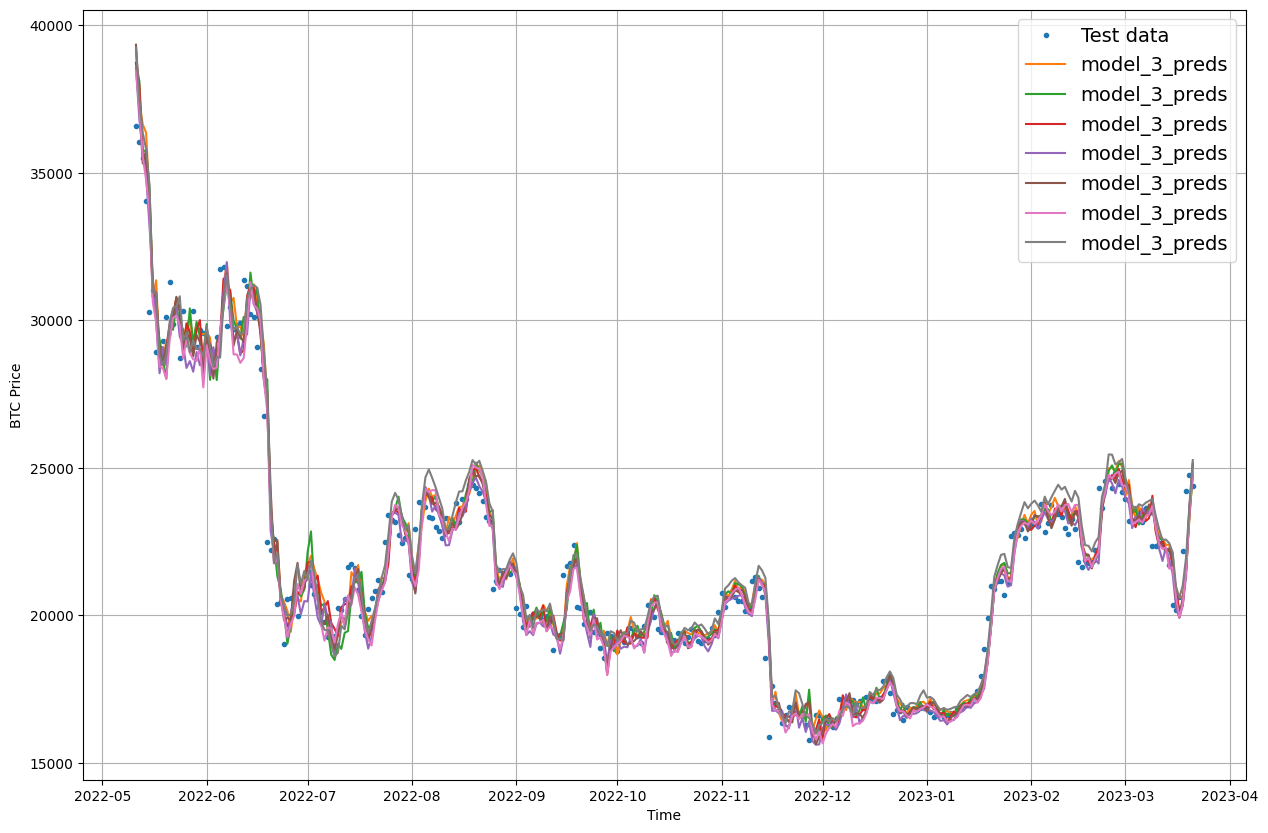

In [66]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

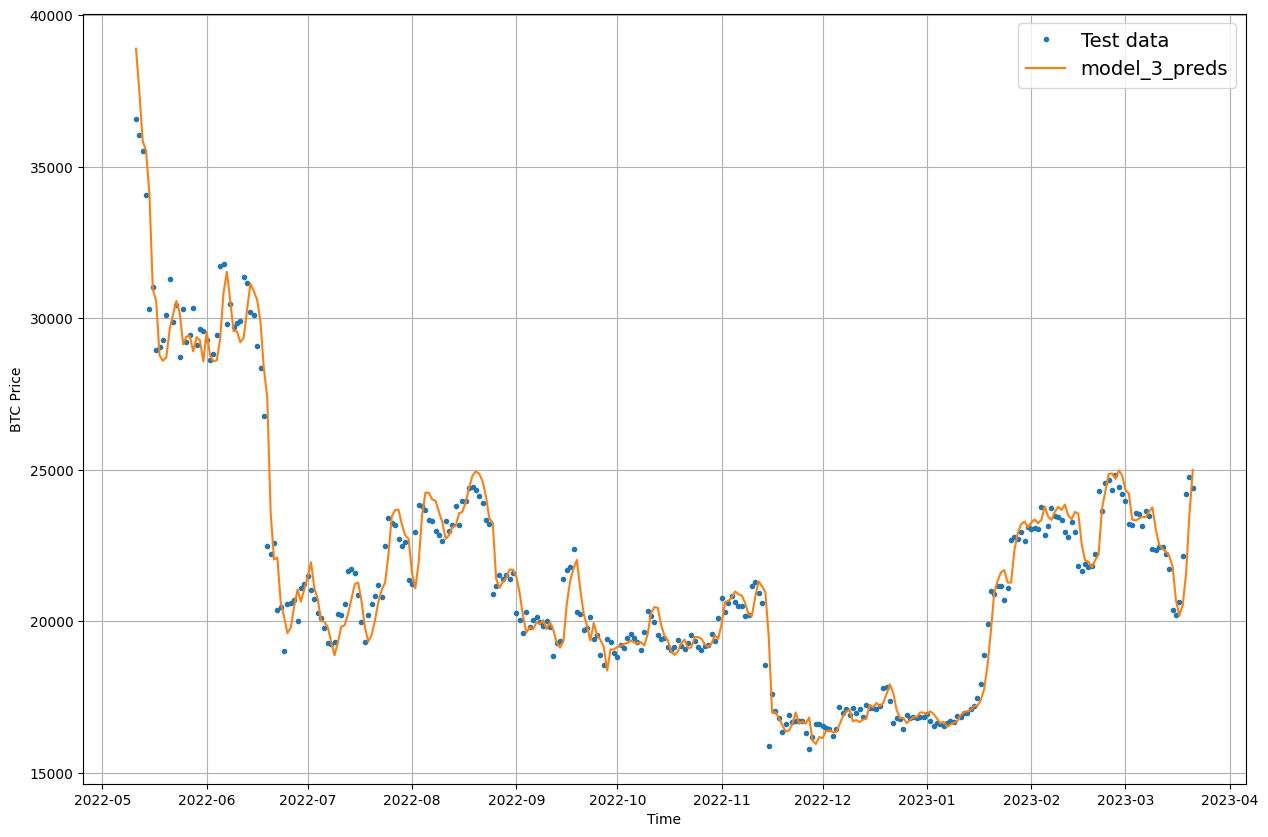

In [67]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

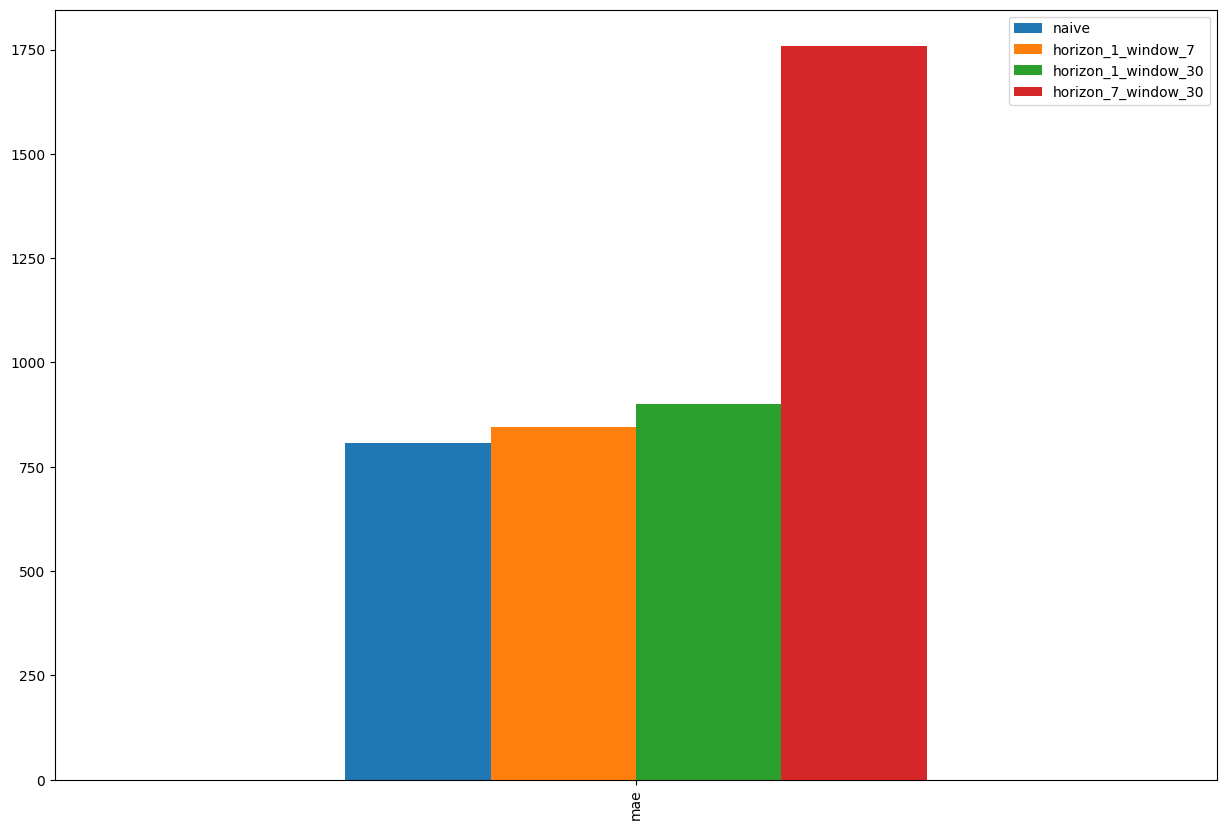

In [68]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4 : Conv1D

We'll be using Conv1D model as it can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is many to one problem).

In [69]:
HORIZON=1
WINDOW_SIZE=7

In [70]:
# make windows for Conv1D model
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2480, 2480, 621, 621)

In [71]:
# let's see how our training data looks like
train_windows[0]

array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])

In [72]:
# convert into tensors
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

Alright, it says the shape is 7 which is the window size. But if we see the doc of [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to convert the shape of inputs into `batch size + (timesteps, input_dim)`

In [73]:
# check the shape
x.shape

TensorShape([7])

We need to convert this into (7,1). Let's create a expand dim layer to convert the inputs shape inside the layer.

In [74]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [75]:
# Test it with the x 
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[457.334],
       [424.44 ],
       [394.796],
       [408.904],
       [398.821],
       [402.152],
       [435.791]], dtype=float32)>

In [76]:
# Create the model

tf.random.set_seed(17)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
 1/20 [>.............................] - ETA: 13s - loss: 8450.9648

20/20 [==============================] - 2s 51ms/step - loss: 4413.8115 - val_loss: 4379.1064
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 1103.3561

20/20 [==============================] - 1s 40ms/step - loss: 927.2606 - val_loss: 2329.3113
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 759.7498

20/20 [==============================] - 1s 39ms/step - loss: 509.3584 - val_loss: 1543.8102
Epoch 4/100
 1/20 [>.............................] - ETA: 0s - loss: 350.2810

20/20 [==============================] - 1s 40ms/step - loss: 443.8219 - val_loss: 1424.2825
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 429.7993

20/20 [==============================] - 1s 61ms/step - loss: 420.0529 - val_loss: 1328.3354
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 408.6857 - val_loss: 1385.0968
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 311.4819

20/20 [==============================] - 1s 59ms/step - loss: 401.9338 - val_loss: 1281.0673
Epoch 8/100
 1/20 [>.............................] - ETA: 0s - loss: 434.3354

20/20 [==============================] - 1s 41ms/step - loss: 421.5172 - val_loss: 1258.5507
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 405.0107 - val_loss: 1292.4349
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 378.8717

20/20 [==============================] - 1s 40ms/step - loss: 381.3513 - val_loss: 1241.3793
Epoch 11/100
 1/20 [>.............................] - ETA: 0s - loss: 357.6638

20/20 [==============================] - 1s 41ms/step - loss: 372.3751 - val_loss: 1227.2471
Epoch 12/100
20/20 [==============================] - 0s 3ms/step - loss: 374.0045 - val_loss: 1347.9364
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 468.9177

20/20 [==============================] - 1s 57ms/step - loss: 365.6537 - val_loss: 1133.6223
Epoch 14/100
20/20 [==============================] - 0s 3ms/step - loss: 350.4176 - val_loss: 1245.7263
Epoch 15/100
20/20 [==============================] - 0s 4ms/step - loss: 346.4986 - val_loss: 1263.5542
Epoch 16/100
 1/20 [>.............................] - ETA: 0s - loss: 343.0579

20/20 [==============================] - 1s 42ms/step - loss: 339.5449 - val_loss: 1070.0869
Epoch 17/100
20/20 [==============================] - 0s 4ms/step - loss: 329.7458 - val_loss: 1237.6099
Epoch 18/100
 1/20 [>.............................] - ETA: 0s - loss: 330.3393

20/20 [==============================] - 1s 40ms/step - loss: 330.7974 - val_loss: 1059.8511
Epoch 19/100
20/20 [==============================] - 0s 4ms/step - loss: 328.6206 - val_loss: 1161.5612
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 331.3901 - val_loss: 1107.0981
Epoch 21/100
 1/20 [>.............................] - ETA: 0s - loss: 338.3125

20/20 [==============================] - 1s 41ms/step - loss: 306.4577 - val_loss: 1042.4479
Epoch 22/100
 1/20 [>.............................] - ETA: 0s - loss: 280.3805

20/20 [==============================] - 1s 42ms/step - loss: 307.9491 - val_loss: 1002.2654
Epoch 23/100
20/20 [==============================] - 0s 4ms/step - loss: 301.8694 - val_loss: 1199.7217
Epoch 24/100
20/20 [==============================] - 0s 4ms/step - loss: 324.4091 - val_loss: 1406.6718
Epoch 25/100
20/20 [==============================] - 0s 4ms/step - loss: 308.6583 - val_loss: 1037.2031
Epoch 26/100
 1/20 [>.............................] - ETA: 0s - loss: 269.5564

20/20 [==============================] - 1s 54ms/step - loss: 291.5070 - val_loss: 987.5739
Epoch 27/100
 1/20 [>.............................] - ETA: 0s - loss: 272.9861

20/20 [==============================] - 1s 59ms/step - loss: 294.9912 - val_loss: 938.0434
Epoch 28/100
 1/20 [>.............................] - ETA: 0s - loss: 244.5437

20/20 [==============================] - 1s 62ms/step - loss: 277.6625 - val_loss: 904.8906
Epoch 29/100
 1/20 [>.............................] - ETA: 0s - loss: 299.7053

20/20 [==============================] - 1s 58ms/step - loss: 274.8614 - val_loss: 902.2747
Epoch 30/100
20/20 [==============================] - 0s 5ms/step - loss: 279.6473 - val_loss: 918.2405
Epoch 31/100
 1/20 [>.............................] - ETA: 0s - loss: 267.4890

20/20 [==============================] - 1s 53ms/step - loss: 274.2210 - val_loss: 891.5183
Epoch 32/100
20/20 [==============================] - 0s 3ms/step - loss: 271.5393 - val_loss: 980.7106
Epoch 33/100
20/20 [==============================] - 0s 3ms/step - loss: 289.6936 - val_loss: 993.4622
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 274.5977 - val_loss: 964.5583
Epoch 35/100
 1/20 [>.............................] - ETA: 0s - loss: 245.3923

20/20 [==============================] - 1s 74ms/step - loss: 278.3780 - val_loss: 882.1354
Epoch 36/100
20/20 [==============================] - 0s 4ms/step - loss: 269.6826 - val_loss: 927.8443
Epoch 37/100
 1/20 [>.............................] - ETA: 0s - loss: 292.3704

20/20 [==============================] - 1s 72ms/step - loss: 272.4136 - val_loss: 875.6982
Epoch 38/100
20/20 [==============================] - 0s 3ms/step - loss: 269.4396 - val_loss: 914.3669
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 284.5476 - val_loss: 878.7776
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 313.2306 - val_loss: 1417.3241
Epoch 41/100
20/20 [==============================] - 0s 3ms/step - loss: 319.5363 - val_loss: 1176.9377
Epoch 42/100
20/20 [==============================] - 0s 3ms/step - loss: 273.5044 - val_loss: 923.0974
Epoch 43/100
 1/20 [>.............................] - ETA: 0s - loss: 299.6816

20/20 [==============================] - 1s 59ms/step - loss: 264.2933 - val_loss: 863.4260
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 262.3428 - val_loss: 891.0035
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 276.7040 - val_loss: 874.5814
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 264.6860 - val_loss: 871.9944
Epoch 47/100
20/20 [==============================] - 0s 3ms/step - loss: 260.7755 - val_loss: 866.0340
Epoch 48/100
 1/20 [>.............................] - ETA: 0s - loss: 249.0688

20/20 [==============================] - 1s 40ms/step - loss: 261.4444 - val_loss: 855.3528
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 265.0078 - val_loss: 871.6927
Epoch 50/100
 1/20 [>.............................] - ETA: 0s - loss: 368.1653

20/20 [==============================] - 1s 40ms/step - loss: 259.1790 - val_loss: 852.8032
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 258.0461 - val_loss: 912.8399
Epoch 52/100
20/20 [==============================] - 0s 4ms/step - loss: 261.1664 - val_loss: 900.8424
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 270.3812 - val_loss: 909.9233
Epoch 54/100
20/20 [==============================] - 0s 3ms/step - loss: 272.6484 - val_loss: 857.9706
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 265.0361 - val_loss: 993.0714
Epoch 56/100
 1/20 [>.............................] - ETA: 0s - loss: 375.4862

20/20 [==============================] - 1s 40ms/step - loss: 285.3947 - val_loss: 851.8708
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 263.6983 - val_loss: 890.3339
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 261.7143 - val_loss: 891.5541
Epoch 59/100
 1/20 [>.............................] - ETA: 0s - loss: 280.9557

20/20 [==============================] - 1s 42ms/step - loss: 257.6996 - val_loss: 849.8163
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 259.5426 - val_loss: 864.1841
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 256.4474 - val_loss: 873.2546
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 262.6186 - val_loss: 912.4569
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 264.8550 - val_loss: 857.3682
Epoch 64/100
20/20 [==============================] - 0s 4ms/step - loss: 254.1979 - val_loss: 870.4349
Epoch 65/100
20/20 [==============================] - 0s 3ms/step - loss: 261.8864 - val_loss: 860.9113
Epoch 66/100
 1/20 [>.............................] - ETA: 0s - loss: 244.9012

20/20 [==============================] - 1s 51ms/step - loss: 264.0712 - val_loss: 846.0334
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 294.9618 - val_loss: 1152.8059
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 259.6423 - val_loss: 899.5073
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 269.3708 - val_loss: 926.6776
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 272.7924 - val_loss: 1179.3214
Epoch 71/100
20/20 [==============================] - 0s 5ms/step - loss: 288.9921 - val_loss: 851.9291
Epoch 72/100
20/20 [==============================] - 0s 5ms/step - loss: 253.8490 - val_loss: 972.8542
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 267.9052 - val_loss: 889.4984
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 250.3476 - val_loss: 881.6650
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 

20/20 [==============================] - 1s 54ms/step - loss: 263.9251 - val_loss: 832.2139
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 263.8771 - val_loss: 872.6550
Epoch 81/100
20/20 [==============================] - 0s 3ms/step - loss: 257.6623 - val_loss: 836.6459
Epoch 82/100
20/20 [==============================] - 0s 3ms/step - loss: 280.5980 - val_loss: 1504.8890
Epoch 83/100
20/20 [==============================] - 0s 3ms/step - loss: 289.2151 - val_loss: 1026.0314
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 286.5899 - val_loss: 914.9901
Epoch 85/100
20/20 [==============================] - 0s 3ms/step - loss: 272.9772 - val_loss: 940.7857
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 257.3787 - val_loss: 883.6730
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 258.4086 - val_loss: 933.1945
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 

20/20 [==============================] - 1s 40ms/step - loss: 273.1364 - val_loss: 827.9118
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss: 248.5524 - val_loss: 935.6876
Epoch 91/100
 1/20 [>.............................] - ETA: 0s - loss: 245.7361

20/20 [==============================] - 1s 39ms/step - loss: 254.4125 - val_loss: 826.5466
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 263.7420 - val_loss: 959.3810
Epoch 93/100
20/20 [==============================] - 0s 3ms/step - loss: 260.8075 - val_loss: 843.5451
Epoch 94/100
20/20 [==============================] - 0s 4ms/step - loss: 249.4076 - val_loss: 1047.5358
Epoch 95/100
20/20 [==============================] - 0s 3ms/step - loss: 280.4516 - val_loss: 1064.7634
Epoch 96/100
20/20 [==============================] - 0s 4ms/step - loss: 266.7992 - val_loss: 890.6260
Epoch 97/100
20/20 [==============================] - 0s 4ms/step - loss: 270.3580 - val_loss: 922.8114
Epoch 98/100
20/20 [==============================] - 0s 3ms/step - loss: 257.5661 - val_loss: 845.4560
Epoch 99/100
20/20 [==============================] - 0s 3ms/step - loss: 255.2281 - val_loss: 907.4310
Epoch 100/100
20/20 [==============================] - 0s 4ms/step - loss:

In [77]:
# check the summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [78]:
# evaluate on the last epochs model
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 860.2213


860.2213134765625

In [79]:
# load the best model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 826.5467


826.5466918945312

In [80]:
# make some predictions
model_4_preds = make_predictions(model_4, test_windows)

# evaluate the results
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_4_preds)

model_4_results

20/20 [==============================] - 0s 1ms/step


{'mae': 826.5467,
 'mse': 1543516.5,
 'rmse': 1242.3834,
 'mape': 2.3925204,
 'mase': 1.0000142}

In [81]:
model_1_results

{'mae': 846.10657,
 'mse': 1617502.5,
 'rmse': 1271.8107,
 'mape': 2.4571233,
 'mase': 1.0000142}

Close enough with `model_1` but not better than it. Let's continue our experiments.

## Model 5 : RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data.

We're not going to change the data, the data will be same just the model architecture would be different.

In [82]:
tf.random.set_seed(17)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# compile the model
model_5.compile(loss='mae',
                optimizer='Adam')

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

In [83]:
# check the summary
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 205,377
Trainable params: 205,377
Non-tr

In [84]:
# evaluate on last epoch
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 859.9259


859.9259033203125

In [85]:
# load the best model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 854.4352


854.4351806640625

In [86]:
# make predictions and check pred results
model_5_preds = make_predictions(model_5, test_windows)

model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

model_5_results

20/20 [==============================] - 0s 2ms/step


{'mae': 854.4353,
 'mse': 1621150.9,
 'rmse': 1273.2443,
 'mape': 2.476523,
 'mase': 1.0000142}

## Make a Multivariate time series

So far all our models predicted on univariate time series data which is only Bitcoin prices, but what are other features that may impact the price of bitcoin, that's the thing to explore.


What about the Volume ? Or Block Reward ? Could be a tweet from a famous personality like Elon Musk can fluctuate the prices. 

According to the data we have, we can use Volume and Block Reward. Then let's add these two features into our time series dataset.

In [88]:
# view the dataset
bitcoin_prices.tail()

,Price
Date,
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,27964.888672


According to the [CMC Markets](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving) block reward events, we can assign the block reward to specific date range in our dataset.

| Block Reward	| Start Date |
| --- | --- |
| 50	| 3 January 2009 (2009-01-03) |
| 25	| 28 November 2012 |
| 12.5 |	9 July 2016 |
| 6.25 |	11 May 2020 |
| 3.125	|TBA (expected 2024) |
| 1.5625 |	TBA (expected 2028) |


And we have a data between **`2014 Sept 17th`** - **`2023 March 17th`**. Great.


In [91]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125 # not required for our dataset

# Block reward dates
block_reward_1_date = np.datetime64("2009-01-03")
block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-11")
block_reward_5_date = np.datetime64("2024-04-01") # expected to be april

Let's get the number of days fall between the block reward dates in our time series dataset.

In [92]:
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_date - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3484)

Now add the new feature `block_reward` in our dataset.

In [97]:
# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column
                          # row, column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

Let's view head and tail of data.

In [106]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [107]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-03-17,27423.929688,6.25
2023-03-18,26965.878906,6.25
2023-03-19,28038.675781,6.25
2023-03-20,27767.236328,6.25
2023-03-21,27964.888672,6.25


Let's plot it to see how it looks like together.

<Axes: xlabel='Date'>

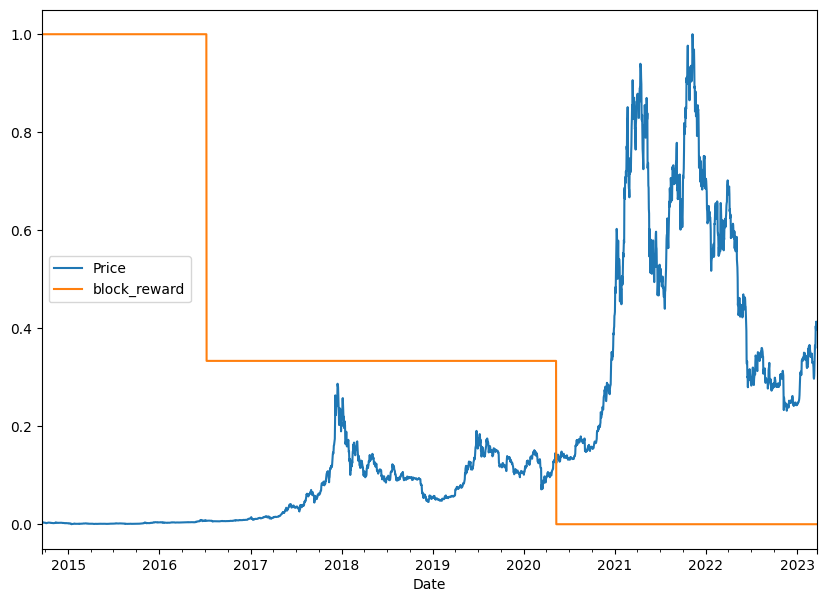

In [108]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

In the above plot when we set the same scale for prices and block reward, we can see the Prices go up when block reward get reduced.

## Making a windowed dataset with pandas

Previously we created some custom function to window our univariate time series.

Since we have added one more variable to our dataset, these functions won't work.

In pandas, there is a function called [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html), which can be used to create windows on multivariate time series dataset.


In [109]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [111]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)               

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


Alright, we need to drop NaNs and make feature set and label set.

In [117]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

# Make train test split
split_size = int(len(X) * 0.8) # 80%
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [118]:
X_train.shape, X_test.shape

((2480, 8), (621, 8))

## Model 6 : Multivariate Time Series (Dense model)

We're going to build the same model like `model_1` architecture and use it to train and make predictions on our multivariate time series data.

In [119]:
tf.random.set_seed(17)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], "model_6_multivariate_dense")

# Compile the model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name="model_6_multivariate_dense")])

Epoch 1/100
 1/20 [>.............................] - ETA: 13s - loss: 6725.9092

20/20 [==============================] - 1s 38ms/step - loss: 3181.6189 - val_loss: 5417.1152
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 1382.9325

20/20 [==============================] - 1s 27ms/step - loss: 673.5198 - val_loss: 1413.2759
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 375.5060

20/20 [==============================] - 1s 28ms/step - loss: 409.9956 - val_loss: 1285.7841
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 376.6930 - val_loss: 1385.2146
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 407.2989

20/20 [==============================] - 1s 28ms/step - loss: 376.1017 - val_loss: 1186.7249
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 363.3642 - val_loss: 1266.7639
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 261.2095

20/20 [==============================] - 1s 28ms/step - loss: 361.2384 - val_loss: 1128.8069
Epoch 8/100
 1/20 [>.............................] - ETA: 0s - loss: 395.4570

20/20 [==============================] - 1s 28ms/step - loss: 372.2480 - val_loss: 1109.6514
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 347.6140 - val_loss: 1256.5782
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 383.3159

20/20 [==============================] - 1s 29ms/step - loss: 337.9525 - val_loss: 1071.4165
Epoch 11/100
20/20 [==============================] - 0s 4ms/step - loss: 323.6190 - val_loss: 1083.8346
Epoch 12/100
 1/20 [>.............................] - ETA: 0s - loss: 407.4770

20/20 [==============================] - 1s 27ms/step - loss: 317.3482 - val_loss: 1017.7880
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 349.3964

20/20 [==============================] - 1s 27ms/step - loss: 310.1697 - val_loss: 1007.8450
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 301.9170 - val_loss: 1161.4662
Epoch 15/100
20/20 [==============================] - 0s 3ms/step - loss: 305.3982 - val_loss: 1064.5474
Epoch 16/100
 1/20 [>.............................] - ETA: 0s - loss: 269.2077

20/20 [==============================] - 1s 27ms/step - loss: 306.4391 - val_loss: 974.3784
Epoch 17/100
20/20 [==============================] - 0s 3ms/step - loss: 296.2105 - val_loss: 1007.4272
Epoch 18/100
20/20 [==============================] - 0s 3ms/step - loss: 292.2278 - val_loss: 995.3076
Epoch 19/100
20/20 [==============================] - 0s 3ms/step - loss: 297.0693 - val_loss: 1260.3259
Epoch 20/100
 1/20 [>.............................] - ETA: 0s - loss: 385.7664

20/20 [==============================] - 1s 28ms/step - loss: 305.7530 - val_loss: 942.5639
Epoch 21/100
20/20 [==============================] - 0s 5ms/step - loss: 292.8929 - val_loss: 979.1824
Epoch 22/100
18/20 [==========================>...] - ETA: 0s - loss: 279.6119

20/20 [==============================] - 1s 49ms/step - loss: 281.3383 - val_loss: 928.7800
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 277.7629 - val_loss: 1164.9214
Epoch 24/100
20/20 [==============================] - 0s 6ms/step - loss: 300.9887 - val_loss: 1019.1945
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 203.9641

20/20 [==============================] - 1s 53ms/step - loss: 273.6077 - val_loss: 916.2532
Epoch 26/100
20/20 [==============================] - 0s 5ms/step - loss: 275.9532 - val_loss: 939.6035
Epoch 27/100
20/20 [==============================] - 0s 15ms/step - loss: 276.8400 - val_loss: 992.9087
Epoch 28/100
15/20 [=====================>........] - ETA: 0s - loss: 275.6662

20/20 [==============================] - 2s 79ms/step - loss: 272.7760 - val_loss: 903.8746
Epoch 29/100
20/20 [==============================] - 0s 10ms/step - loss: 267.6485 - val_loss: 906.3464
Epoch 30/100
20/20 [==============================] - 0s 14ms/step - loss: 274.1217 - val_loss: 951.8447
Epoch 31/100
20/20 [==============================] - 0s 11ms/step - loss: 271.4435 - val_loss: 1030.0267
Epoch 32/100
20/20 [==============================] - 0s 7ms/step - loss: 277.8623 - val_loss: 1014.8156
Epoch 33/100
20/20 [==============================] - 0s 11ms/step - loss: 287.0424 - val_loss: 998.7768
Epoch 34/100
20/20 [==============================] - 0s 10ms/step - loss: 272.0538 - val_loss: 942.3093
Epoch 35/100
17/20 [========================>.....] - ETA: 0s - loss: 276.9939

20/20 [==============================] - 1s 38ms/step - loss: 282.4124 - val_loss: 900.4989
Epoch 36/100
20/20 [==============================] - 0s 5ms/step - loss: 267.0531 - val_loss: 963.0178
Epoch 37/100
20/20 [==============================] - 0s 6ms/step - loss: 275.5859 - val_loss: 937.7914
Epoch 38/100
20/20 [==============================] - 0s 7ms/step - loss: 267.4007 - val_loss: 908.2365
Epoch 39/100
20/20 [==============================] - 0s 5ms/step - loss: 280.4504 - val_loss: 943.6363
Epoch 40/100
20/20 [==============================] - 0s 6ms/step - loss: 297.2181 - val_loss: 1408.8314
Epoch 41/100
20/20 [==============================] - 0s 6ms/step - loss: 316.6126 - val_loss: 1416.4835
Epoch 42/100
20/20 [==============================] - 0s 7ms/step - loss: 285.6875 - val_loss: 916.7202
Epoch 43/100
19/20 [===========================>..] - ETA: 0s - loss: 263.7191

20/20 [==============================] - 1s 54ms/step - loss: 260.7240 - val_loss: 867.2155
Epoch 44/100
20/20 [==============================] - 0s 6ms/step - loss: 260.9277 - val_loss: 901.5574
Epoch 45/100
20/20 [==============================] - 0s 7ms/step - loss: 268.4054 - val_loss: 873.7745
Epoch 46/100
13/20 [==================>...........] - ETA: 0s - loss: 265.6304

20/20 [==============================] - 1s 59ms/step - loss: 261.5789 - val_loss: 861.1387
Epoch 47/100
 1/20 [>.............................] - ETA: 0s - loss: 173.6523

20/20 [==============================] - 1s 78ms/step - loss: 260.4014 - val_loss: 858.8087
Epoch 48/100
20/20 [==============================] - 0s 5ms/step - loss: 255.3868 - val_loss: 865.3303
Epoch 49/100
20/20 [==============================] - 0s 7ms/step - loss: 258.7729 - val_loss: 859.5197
Epoch 50/100
19/20 [===========================>..] - ETA: 0s - loss: 259.7421

20/20 [==============================] - 1s 45ms/step - loss: 259.0260 - val_loss: 853.8569
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 259.4411 - val_loss: 917.3792
Epoch 52/100
 1/20 [>.............................] - ETA: 0s - loss: 242.4991

20/20 [==============================] - 1s 48ms/step - loss: 254.7630 - val_loss: 851.2542
Epoch 53/100
20/20 [==============================] - 0s 6ms/step - loss: 254.7786 - val_loss: 858.8562
Epoch 54/100
20/20 [==============================] - 0s 6ms/step - loss: 267.7959 - val_loss: 874.0000
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 257.5996 - val_loss: 944.6198
Epoch 56/100
 1/20 [>.............................] - ETA: 0s - loss: 362.0242

20/20 [==============================] - 1s 52ms/step - loss: 266.1073 - val_loss: 847.6898
Epoch 57/100
 1/20 [>.............................] - ETA: 0s - loss: 249.3521

20/20 [==============================] - 1s 34ms/step - loss: 267.4950 - val_loss: 841.4172
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 264.4748 - val_loss: 994.2424
Epoch 59/100
20/20 [==============================] - 0s 7ms/step - loss: 258.3564 - val_loss: 843.3573
Epoch 60/100
20/20 [==============================] - 0s 5ms/step - loss: 252.3224 - val_loss: 842.0065
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 257.6434 - val_loss: 860.4196
Epoch 62/100
20/20 [==============================] - 0s 10ms/step - loss: 256.4794 - val_loss: 937.9749
Epoch 63/100
20/20 [==============================] - 0s 12ms/step - loss: 262.4071 - val_loss: 973.1895
Epoch 64/100
19/20 [===========================>..] - ETA: 0s - loss: 259.7496

20/20 [==============================] - 1s 65ms/step - loss: 259.1932 - val_loss: 837.3515
Epoch 65/100
20/20 [==============================] - 0s 6ms/step - loss: 264.5530 - val_loss: 838.1531
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 268.3195 - val_loss: 851.0839
Epoch 67/100
20/20 [==============================] - 0s 12ms/step - loss: 287.2436 - val_loss: 1102.3387
Epoch 68/100
 1/20 [>.............................] - ETA: 0s - loss: 243.6852

20/20 [==============================] - 1s 49ms/step - loss: 255.4380 - val_loss: 833.4525
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 252.9581 - val_loss: 1018.9485
Epoch 70/100
20/20 [==============================] - 0s 3ms/step - loss: 269.8588 - val_loss: 948.4499
Epoch 71/100
20/20 [==============================] - 0s 3ms/step - loss: 261.1397 - val_loss: 848.2894
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 259.0798 - val_loss: 999.8294
Epoch 73/100
20/20 [==============================] - 0s 9ms/step - loss: 268.2109 - val_loss: 889.8029
Epoch 74/100
20/20 [==============================] - 0s 6ms/step - loss: 249.8749 - val_loss: 892.5248
Epoch 75/100
20/20 [==============================] - 0s 6ms/step - loss: 272.5324 - val_loss: 834.6174
Epoch 76/100
20/20 [==============================] - 0s 4ms/step - loss: 255.3068 - val_loss: 846.6372
Epoch 77/100
20/20 [==============================] - 0s 3ms/step - loss: 2

20/20 [==============================] - 1s 45ms/step - loss: 252.9639 - val_loss: 828.2469
Epoch 80/100
20/20 [==============================] - 0s 6ms/step - loss: 259.6532 - val_loss: 938.5388
Epoch 81/100
20/20 [==============================] - 0s 7ms/step - loss: 260.3275 - val_loss: 835.6248
Epoch 82/100
20/20 [==============================] - 0s 6ms/step - loss: 275.5380 - val_loss: 1281.5773
Epoch 83/100
20/20 [==============================] - 0s 5ms/step - loss: 284.7374 - val_loss: 988.2972
Epoch 84/100
20/20 [==============================] - 0s 6ms/step - loss: 302.5449 - val_loss: 1005.1451
Epoch 85/100
20/20 [==============================] - 0s 5ms/step - loss: 283.7785 - val_loss: 876.9333
Epoch 86/100
20/20 [==============================] - 0s 6ms/step - loss: 255.4128 - val_loss: 892.5367
Epoch 87/100
 1/20 [>.............................] - ETA: 0s - loss: 206.9488

20/20 [==============================] - 1s 44ms/step - loss: 260.2764 - val_loss: 825.0319
Epoch 88/100
20/20 [==============================] - 0s 6ms/step - loss: 251.5302 - val_loss: 844.0455
Epoch 89/100
20/20 [==============================] - 0s 6ms/step - loss: 258.8118 - val_loss: 827.1346
Epoch 90/100
20/20 [==============================] - 0s 11ms/step - loss: 248.5287 - val_loss: 983.4861
Epoch 91/100
20/20 [==============================] - 0s 10ms/step - loss: 254.6161 - val_loss: 836.7487
Epoch 92/100
20/20 [==============================] - 0s 11ms/step - loss: 252.5417 - val_loss: 890.6317
Epoch 93/100
20/20 [==============================] - 0s 12ms/step - loss: 255.2246 - val_loss: 826.7106
Epoch 94/100
20/20 [==============================] - 0s 12ms/step - loss: 250.5500 - val_loss: 1007.4288
Epoch 95/100
20/20 [==============================] - 0s 8ms/step - loss: 281.4706 - val_loss: 896.1885
Epoch 96/100
20/20 [==============================] - 0s 11ms/step - l

In [120]:
# evaluate on last epoch
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 844.9553


844.955322265625

In [121]:
# load the best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate_dense/")
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 3ms/step - loss: 825.0319


825.0319213867188

In [122]:
# Make prediction
model_6_preds = make_predictions(model_6, X_test)

model_6_preds[:2]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([32914.98 , 33576.516], dtype=float32)>

In [123]:
# evaluate preds
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 825.0318,
 'mse': 1535831.8,
 'rmse': 1239.2867,
 'mape': 2.3835835,
 'mase': 1.0000142}

In [125]:
model_1_results

{'mae': 846.10657,
 'mse': 1617502.5,
 'rmse': 1271.8107,
 'mape': 2.4571233,
 'mase': 1.0000142}

Oh great, we got the better results than `model_1` but still `naive forecast` is the best so far.